# let's import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score
import collections

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# let's extract train

In [2]:
train = pd.read_csv('train.csv')
train.head(5)

,id,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,21983,18,Private,141363,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,40,United-States,0
1,10063,38,Private,179579,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,?,1
2,16273,63,Private,172740,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,0
3,2208,35,Private,47707,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Female,0,0,40,United-States,1
4,15914,32,Private,48458,HS-grad,9,Never-married,Sales,Own-child,Black,Female,0,1669,45,United-States,0


In [3]:
test = pd.read_csv('test.csv')
test.head(5)

,id,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,18738,22,Private,110684,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States
1,14083,26,Local-gov,242464,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,3103,0,40,United-States
2,6172,47,Private,170850,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,4064,0,60,United-States
3,2821,32,Federal-gov,454508,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States
4,11725,37,Federal-gov,194630,Masters,14,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States


# let's transform data

In [4]:
from sklearn.preprocessing import LabelEncoder

In [35]:
train.shape[0]

15792

In [15]:
def transform_df(train, test):
    united = train.append(test)
    united = united.rename(columns=lambda x: x.strip()).drop(labels=['target'], axis=1)
    
    n_col = []
    c_col = []
    for k,v in united.dtypes.to_dict().items():
        if v == 'int64':
            n_col.append(k)
        else:
            c_col.append(k)

    #train[c_col] = train[c_col].apply(lambda x: x.str.strip(), axis=1)
    #test[c_col] = test[c_col].apply(lambda x: x.str.strip(), axis=1)
    united[c_col] = united[c_col].apply(lambda x: x.str.strip(), axis=1)

    #sex
    #train['sex_b'] = train['sex'].map({'Male':1, 'Female':0})
    #train = train.drop(labels=['sex'], axis = 1)
    #test['sex_b'] = test['sex'].map({'Male':1, 'Female':0})
    #test = test.drop(labels=['sex'], axis = 1)
    
    united['sex_b'] = united['sex'].map({'Male':1, 'Female':0})
    united = united.drop(labels=['sex'], axis = 1)
    
    #married
    #не была замужем, разведенка, вдова, разбежались 
    one = ['Never-married','Divorced','Widowed','Separated']
    #так или иначе женатики, гражданский и прочий браки
    two = ['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse']
    
    #train['marital-status_b'] = train['marital-status'].apply(lambda x: 1 if x in one else 0)
    #train = train.drop(labels=['marital-status'], axis = 1)
    #test['marital-status_b'] = test['marital-status'].apply(lambda x: 1 if x in one else 0)
    #test = test.drop(labels=['marital-status'], axis = 1)
    
    united['marital-status_b'] = united['marital-status'].apply(lambda x: 1 if x in one else 0)
    
    #others
    #le = LabelEncoder()
    #for x in ['workclass', 'occupation', 'race', 'relationship', 'native-country']:
    #    le.fit(united[x])
    #    train[x] = le.transform(train[x])
    #    test[x] = le.transform(test[x])
    
    united = pd.get_dummies(united, columns=['workclass', 'occupation', 'race', 'relationship', 'native-country'])
       
    
    #train = train.drop(labels=['fnlwgt', 'education'], axis = 1)
    #test = test.drop(labels=['fnlwgt', 'education'], axis = 1)

    #train = train.drop(labels=['race', 'relationship', 'native-country', 'capital-gain', 'capital-loss', 'race', 'sex_b', 'marital-status_b'], axis=1)
    #test = test.drop(labels=['race', 'relationship', 'native-country', 'capital-gain', 'capital-loss', 'race', 'sex_b', 'marital-status_b'], axis=1)
    
    united = united.drop(labels=['education', 'fnlwgt', 'marital-status'], axis=1)
    #united = united.drop(labels=['education', 'fnlwgt','workclass', 'occupation', 'race', 'relationship', 'native-country', 'marital-status'], axis=1)
    
    target = train['target']
    train = united[:train.shape[0]]
    train['target'] = target
    test = united[train.shape[0]:]
    
    return train, test

In [16]:
train_tr, test_tr = transform_df(train, test)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
train_tr.head()

,age,capital-gain,capital-loss,education-num,hours-per-week,id,sex_b,marital-status_b,workclass_?,workclass_Federal-gov,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,target
0,18,0,0,10,40,21983,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,38,0,0,10,50,10063,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,63,0,0,10,40,16273,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,35,0,0,9,40,2208,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,32,0,1669,9,45,15914,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [35]:
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

# let's try model

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [18]:
Y = train_tr.target.values
X = train_tr.drop(['target', 'id'], axis = 1).values
size = 0.2
seed = 10

X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,test_size=size,random_state=seed)

kfold = KFold(n_splits = 4, random_state = seed)

cv_res = cross_val_score(GradientBoostingClassifier(n_estimators=10000), X_train, Y_train, cv=kfold, scoring = 'f1', n_jobs=-1, verbose=-1)

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  7.2min finished


In [19]:
print(cv_res.mean(), cv_res.std())

0.15261556378483254 0.00456954255949673


# let's try to improve

In [84]:
n_estimators = np.array([50,100,200,250])
max_features = np.array([1,3,5])

grid_p = dict(n_estimators = n_estimators, max_features = max_features)
md = RandomForestClassifier()
kfold = KFold(4, random_state = 10)

grid_cv = GridSearchCV(estimator = md, param_grid = grid_p, scoring = 'f1', cv = kfold, n_jobs=-1)
grid_res = grid_cv.fit(X_train, Y_train)

means = grid_res.cv_results_['mean_test_score']
stds = grid_res.cv_results_['std_test_score']
params = grid_res.cv_results_['params']

In [85]:
for m,s,p in zip(means,stds,params):
    print(p,m,s)

{'max_features': 1, 'n_estimators': 50} 0.13249933255059335 0.01215536749279584
{'max_features': 1, 'n_estimators': 100} 0.13676314380737578 0.011469284008448297
{'max_features': 1, 'n_estimators': 200} 0.13014023317671347 0.011118635554689399
{'max_features': 1, 'n_estimators': 250} 0.13096520867177117 0.012102157678035151
{'max_features': 3, 'n_estimators': 50} 0.13146271893498943 0.022576160469222735
{'max_features': 3, 'n_estimators': 100} 0.12990532977443506 0.015299844603911338
{'max_features': 3, 'n_estimators': 200} 0.13020566670819525 0.013762975868112558
{'max_features': 3, 'n_estimators': 250} 0.12464896886813309 0.013269894147221706
{'max_features': 5, 'n_estimators': 50} 0.13647681221231206 0.012106673882083247
{'max_features': 5, 'n_estimators': 100} 0.1417848094471126 0.009397194982162673
{'max_features': 5, 'n_estimators': 200} 0.13812939106925834 0.011721674650086137
{'max_features': 5, 'n_estimators': 250} 0.13540834413160027 0.011343116238826261


In [23]:
md = GradientBoostingClassifier(n_estimators=30000)
md.fit(X_train, Y_train)
prd = md.predict(X_validation)

print((100*accuracy_score(Y_validation, prd)))

67.01487812598924


# let's check test

In [67]:
diff(df.columns.values, df_t.columns.values)

['target']

In [21]:
X_t = test_tr.drop(['id'], axis = 1).values

prd_t = md.predict(X_t)

In [13]:
collections.Counter(prd_t)

Counter({0: 5832, 1: 937})

In [22]:
df_t = pd.DataFrame()
df_t['target'] = prd_t.tolist()
df_t['Index'] = test_tr['id']
df_t[['Index','target']].to_csv("pkd.csv", header=['Index','target'], index=False)

In [69]:
import matplotlib.pyplot as plt

In [65]:
def plot_importance(clf, X):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(20, 8))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices])
    plt.xlim([-1, X.shape[1]])
    plt.show()

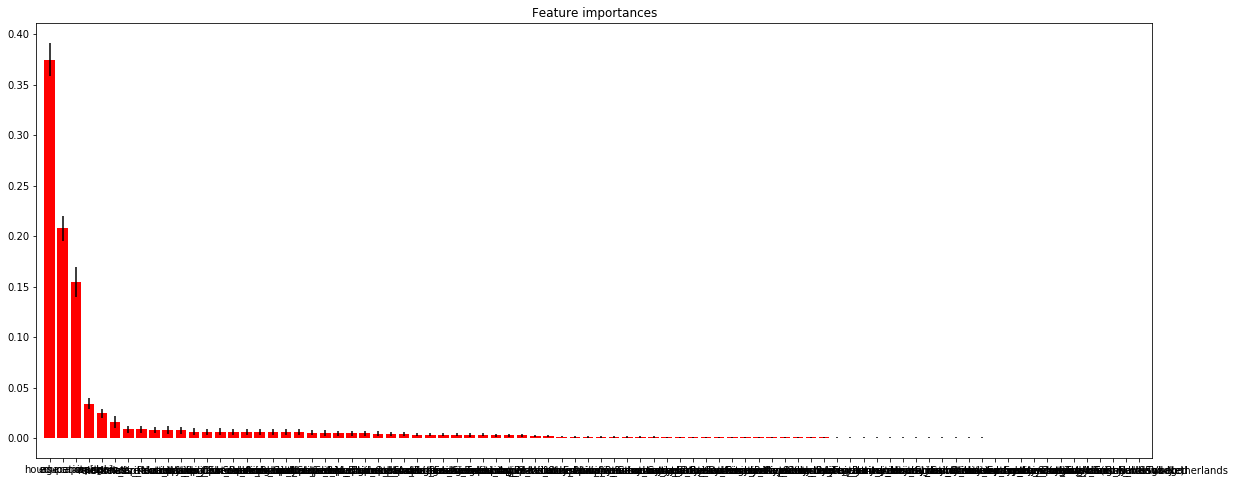

In [70]:
plot_importance(md, test_tr.drop(columns=['id'], axis=1))

In [71]:
feature_importances = pd.DataFrame(md.feature_importances_, index = test_tr.drop(columns=['id'], axis=1).columns, columns=['importance']).sort_values('importance', ascending=False)

In [72]:
feature_importances

,importance
age,0.374846
hours-per-week,0.207623
education-num,0.154449
capital-gain,0.033952
capital-loss,0.024353
sex_b,0.015782
workclass_Private,0.008601
relationship_Not-in-family,0.008590
marital-status_b,0.008069
race_White,0.007648
